In [3]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 300)
pd.set_option('display.width', 200)

In [4]:
# ---------------------------
# 0. Configuration
# ---------------------------
DATA_DIR = Path("data")
BENEFICIARY_FILE = DATA_DIR / "Train_Beneficiarydata.csv"
INPATIENT_FILE   = DATA_DIR / "Train_Inpatientdata.csv"
OUTPATIENT_FILE  = DATA_DIR / "Train_Outpatientdata.csv"
LABELS_FILE      = DATA_DIR / "Train_labels.csv"

In [ ]:
# ---------------------------
# 1. Helpers
# ---------------------------

def parse_dates(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')

def print_missing_summary(df, name, top_n=10):
    miss = (df.isnull().mean()*100).sort_values(ascending=False)
    print(f"\nMissingness summary for {name} (top {top_n}):")
    print(miss.head(top_n).round(2))

def print_dup_counts(df, name):
    dup = df.duplicated().sum()
    print(f"{name}: {dup} duplicate rows")

def safe_info(df, name):
    print(f"\n-- {name} info --")
    print(df.info(verbose=False))
    print_missing_summary(df, name)
    print_dup_counts(df, name)

In [11]:
# ---------------------------
# 2. Load Data
# ---------------------------
bene_df = pd.read_csv("../data/Test_Beneficiarydata-1542969243754.csv")
inp_df  = pd.read_csv("../data/Test_Inpatientdata-1542969243754.csv")
out_df  = pd.read_csv("../data/Test_Outpatientdata-1542969243754.csv")
prov_df = pd.read_csv('../data/Test_labels.csv')

# Quick inspection (first rows)
print("\nBeneficiary sample:")
display(bene_df.head(2))
print("\nInpatient sample:")
display(inp_df.head(2))
print("\nOutpatient sample:")
display(out_df.head(2))
print("\nLabels sample:")
display(prov_df.head(2))



Beneficiary sample:


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,1,1,2,2,2,2,1,2,1,1,2,0,0,1490,160



Inpatient sample:


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000,PHY317786,PHY427017,NaN,2009-09-09,5789,1068.0,2009-09-16,332,5780,5533,496,V420,40390,2851,5990,570,41071,4280,4443.0,5849.0,NaN,NaN,NaN,NaN
1,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000,PHY314656,PHY426644,NaN,2008-12-25,5939,1068.0,2009-01-08,661,1889,41071,5990,5601,4588,5845,4549,29570,34831,NaN,5551.0,NaN,NaN,NaN,NaN,NaN



Outpatient sample:


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,NaN,PHY347633,V5832,V5861,2724,3182,V5869,42731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,NaN,PHY381777,9594,E9174,4019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN



Labels sample:


,Provider
0,PRV51002
1,PRV51006


In [12]:
# ---------------------------
# 3. Basic Validation & Date Parsing
# ---------------------------
# We know inpatient/outpatient have: ClaimStartDt, ClaimEndDt, AdmissionDt, DischargeDt
date_cols_common = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt', 'DOB', 'DOD']
parse_dates(bene_df, date_cols_common)
parse_dates(inp_df, date_cols_common)
parse_dates(out_df, date_cols_common)

# Print basic info
safe_info(bene_df, "Beneficiary")
safe_info(inp_df,  "Inpatient")
safe_info(out_df,  "Outpatient")
safe_info(prov_df, "Labels")


-- Beneficiary info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63968 entries, 0 to 63967
Columns: 25 entries, BeneID to OPAnnualDeductibleAmt
dtypes: datetime64[ns](2), int64(21), object(2)
memory usage: 12.2+ MB
None

Missingness summary for Beneficiary (top 10):
DOD                      99.1
BeneID                    0.0
DOB                       0.0
Gender                    0.0
Race                      0.0
RenalDiseaseIndicator     0.0
State                     0.0
County                    0.0
NoOfMonths_PartACov       0.0
NoOfMonths_PartBCov       0.0
dtype: float64
Beneficiary: 0 duplicate rows

-- Inpatient info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Columns: 30 entries, BeneID to ClmProcedureCode_6
dtypes: datetime64[ns](4), float64(7), int64(1), object(18)
memory usage: 2.2+ MB
None

Missingness summary for Inpatient (top 10):
ClmProcedureCode_6     100.00
ClmProcedureCode_5      99.98
ClmProcedureCode_4      99.70
ClmProcedur

In [13]:
# ---------------------------
# 4. Logical Date Checks & Data Quality
# ---------------------------
print("\n--- Date consistency checks ---")

# Inpatient & Outpatient: ClaimStartDt <= ClaimEndDt
for name, df in [("Inpatient", inp_df), ("Outpatient", out_df)]:
    if 'ClaimStartDt' in df.columns and 'ClaimEndDt' in df.columns:
        bad = df[df['ClaimStartDt'] > df['ClaimEndDt']]
        print(f"{name}: {len(bad)} claims where ClaimStartDt > ClaimEndDt")

# Claims after death (merge claim-level with DOD from beneficiary)
if 'DOD' in bene_df.columns:
    temp_in = inp_df.merge(bene_df[['BeneID', 'DOD']], on='BeneID', how='left')
    cad_in = temp_in[(temp_in['DOD'].notna()) & (temp_in['ClaimStartDt'] > temp_in['DOD'])]
    print(f"Inpatient claims after death: {len(cad_in)}")
    
    temp_out = out_df.merge(bene_df[['BeneID', 'DOD']], on='BeneID', how='left')
    cad_out = temp_out[(temp_out['DOD'].notna()) & (temp_out['ClaimStartDt'] > temp_out['DOD'])]
    print(f"Outpatient claims after death: {len(cad_out)}")
else:
    print("DOD not present in beneficiary data; skipping claims-after-death check.")



--- Date consistency checks ---
Inpatient: 0 claims where ClaimStartDt > ClaimEndDt
Outpatient: 0 claims where ClaimStartDt > ClaimEndDt
Inpatient claims after death: 0
Outpatient claims after death: 0


In [24]:
# -----------------------------------------
# 4.1 MERGING STRATEGY — REQUIRED FOR MODEL
# -----------------------------------------

# Tag inpatient / outpatient
inp_df['ClaimType'] = 'Inpatient'
out_df['ClaimType'] = 'Outpatient'

# Combine both into one claims dataset
all_claims = pd.concat([inp_df, out_df], ignore_index=True)

# Merge to attach patient details (DOB, chronic conditions...)
claims_with_bene = pd.merge(
    all_claims,
    bene_df,
    on='BeneID',
    how='left'
)

# Create provider-level features
provider_features = claims_with_bene.groupby('Provider').agg({
    'ClaimID': 'count',                       # Total number of claims
    'InscClaimAmtReimbursed': 'sum',          # Total reimbursement $$ 
    'BeneID': 'nunique',                      # Number of unique patients
    'ClaimType': lambda x: (x == 'Inpatient').sum()  # Count inpatient claims
}).reset_index()

provider_features.columns = [
    'Provider', 
    'TotalClaims', 
    'TotalReimbursement', 
    'UniquePatients', 
    'InpatientCount'
]

# Merge with training labels
final_dataset = pd.merge(
    prov_df,                # Has Provider + PotentialFraud
    provider_features, 
    on='Provider', 
    how='left'
).fillna(0)


In [14]:
# ---------------------------
# 5. Beneficiary-level Feature Engineering
# ---------------------------
# Age, ChronicCount, DaysToDeath
print("\n--- Beneficiary feature engineering ---")
if 'DOB' in bene_df.columns:
    # compute age as of a fixed reference (or use today's date)
    ref_date = pd.Timestamp("2025-01-01")
    bene_df['DOB'] = pd.to_datetime(bene_df['DOB'], errors='coerce')
    bene_df['Age'] = ((ref_date - bene_df['DOB']).dt.days / 365.25).round(1)
else:
    bene_df['Age'] = np.nan

# Detect chronic condition columns (common Kaggle naming like ChronicCond_* or Chronic*)
chronic_candidates = [c for c in bene_df.columns if ('Chronic' in c or 'chronic' in c or 'ChronicCond' in c)]
print("Detected chronic columns (sample):", chronic_candidates[:10])
if len(chronic_candidates) > 0:
    bene_df['ChronicCount'] = bene_df[chronic_candidates].sum(axis=1)
else:
    # If none exist, create a zero column so downstream code doesn't break
    bene_df['ChronicCount'] = 0

# Days to death (if DOD present)
if 'DOD' in bene_df.columns:
    bene_df['DOD'] = pd.to_datetime(bene_df['DOD'], errors='coerce')
    bene_df['DaysToDeath'] = (bene_df['DOD'] - bene_df['DOB']).dt.days
else:
    bene_df['DaysToDeath'] = np.nan

print("Beneficiary features added: Age, ChronicCount, DaysToDeath")
display(bene_df[['BeneID','Age','ChronicCount']].head())


--- Beneficiary feature engineering ---
Detected chronic columns (sample): ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis']
Beneficiary features added: Age, ChronicCount, DaysToDeath


,BeneID,Age,ChronicCount
0,BENE11001,82.0,15
1,BENE11007,84.3,17
2,BENE11010,88.5,16
3,BENE11011,110.8,16
4,BENE11014,86.8,17


In [15]:
# ---------------------------
# 6. Claim-level Feature Engineering (Inpatient & Outpatient)
# ---------------------------
print("\n--- Claim-level features (inpatient/outpatient) ---")

# Ensure monetary column numeric
for df, name in [(inp_df, "Inpatient"), (out_df, "Outpatient")]:
    if 'InscClaimAmtReimbursed' in df.columns:
        df['InscClaimAmtReimbursed'] = pd.to_numeric(df['InscClaimAmtReimbursed'], errors='coerce').fillna(0)

# Compute LOS for inpatient (DischargeDt - AdmissionDt)
if ('DischargeDt' in inp_df.columns) and ('AdmissionDt' in inp_df.columns):
    inp_df['LOS'] = (inp_df['DischargeDt'] - inp_df['AdmissionDt']).dt.days
    # clamp negative stays to NaN (we may mark them later)
    inp_df.loc[inp_df['LOS'] < 0, 'LOS'] = np.nan
    print("Inpatient LOS computed.")
else:
    inp_df['LOS'] = np.nan
    print("Inpatient LOS not computed (missing date columns).")

# Mark ClaimType and concat claims
inp_df['ClaimType'] = 'Inpatient'
out_df['ClaimType'] = 'Outpatient'
claims = pd.concat([inp_df, out_df], ignore_index=True, sort=False)
print("Combined claims shape:", claims.shape)

# Merge beneficiary-level derived fields (Age, ChronicCount, DOD) into claims
claims = claims.merge(bene_df[['BeneID','Age','ChronicCount','DOD']], on='BeneID', how='left')

# Flags: claim after death, bad date
claims['ClaimAfterDeath'] = np.where((claims['DOD'].notna()) & (claims['ClaimStartDt'] > claims['DOD']), 1, 0)
claims['BadDate'] = np.where((claims['ClaimStartDt'].notna()) & (claims['ClaimEndDt'].notna()) & (claims['ClaimStartDt'] > claims['ClaimEndDt']), 1, 0)

# Quick check: number of unique providers in claims
print("Unique providers in claims:", claims['Provider'].nunique())


--- Claim-level features (inpatient/outpatient) ---
Inpatient LOS computed.
Combined claims shape: (135392, 32)
Unique providers in claims: 1353


In [16]:
# ---------------------------
# 7. Provider-level Aggregations (rich feature set)
# ---------------------------
print("\n--- Provider-level aggregation (building modeling unit) ---")

# Aggregations we will compute per provider
provider_agg = claims.groupby('Provider').agg(
    TotalClaims = ('ClaimID', 'count'),
    TotalReimbursement = ('InscClaimAmtReimbursed', 'sum'),
    MeanClaimReimb = ('InscClaimAmtReimbursed', 'mean'),
    MaxClaimReimb = ('InscClaimAmtReimbursed', 'max'),
    StdClaimReimb = ('InscClaimAmtReimbursed', 'std'),
    UniquePatients = ('BeneID', 'nunique'),
    InpatientCount = ('ClaimType', lambda x: (x=='Inpatient').sum()),
    OutpatientCount = ('ClaimType', lambda x: (x=='Outpatient').sum()),
    AvgLOS = ('LOS', 'mean'),
    MaxLOS = ('LOS', 'max'),
    MeanAge = ('Age', 'mean'),
    MeanChronicCount = ('ChronicCount', 'mean'),
    ClaimsAfterDeath = ('ClaimAfterDeath', 'sum'),
    BadDateCount = ('BadDate', 'sum')
).reset_index()

# Replace NaN std with 0
provider_agg['StdClaimReimb'] = provider_agg['StdClaimReimb'].fillna(0)

# Derived ratios and features
provider_agg['AvgClaimCost'] = provider_agg['TotalReimbursement'] / provider_agg['TotalClaims']
provider_agg['ClaimsPerPatient'] = provider_agg['TotalClaims'] / provider_agg['UniquePatients']
provider_agg['InpatientRatio'] = provider_agg['InpatientCount'] / provider_agg['TotalClaims']
provider_agg['OutpatientRatio'] = provider_agg['OutpatientCount'] / provider_agg['TotalClaims']
provider_agg['HighValueClaimPerc'] = (claims[claims['InscClaimAmtReimbursed'] > provider_agg['MeanClaimReimb'].median()]
                                      .groupby('Provider').size() / provider_agg['TotalClaims']).fillna(0)

# Percent of claims after death / bad dates
provider_agg['PercClaimsAfterDeath'] = provider_agg['ClaimsAfterDeath'] / provider_agg['TotalClaims']
provider_agg['PercBadDates'] = provider_agg['BadDateCount'] / provider_agg['TotalClaims']

# Fill any infinite or NaN values arising from division by zero
provider_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
provider_agg.fillna(0, inplace=True)

print("Provider features shape:", provider_agg.shape)
display(provider_agg.head())



--- Provider-level aggregation (building modeling unit) ---
Provider features shape: (1353, 22)


,Provider,TotalClaims,TotalReimbursement,MeanClaimReimb,MaxClaimReimb,StdClaimReimb,UniquePatients,InpatientCount,OutpatientCount,AvgLOS,MaxLOS,MeanAge,MeanChronicCount,ClaimsAfterDeath,BadDateCount,AvgClaimCost,ClaimsPerPatient,InpatientRatio,OutpatientRatio,HighValueClaimPerc,PercClaimsAfterDeath,PercBadDates
0,PRV51002,205,53790,262.390244,6010,609.021752,169,0,205,0.000000,0.0,87.412683,17.751220,0,0,262.390244,1.213018,0.000000,1.000000,0.0,0.0,0.0
1,PRV51006,102,30720,301.176471,2300,520.835760,81,0,102,0.000000,0.0,89.847059,17.500000,0,0,301.176471,1.259259,0.000000,1.000000,0.0,0.0,0.0
2,PRV51009,39,27230,698.205128,11000,1934.691424,30,2,37,3.000000,3.0,84.658974,17.897436,0,0,698.205128,1.300000,0.051282,0.948718,0.0,0.0,0.0
3,PRV51010,38,64580,1699.473684,20000,4480.813118,25,6,32,3.833333,8.0,90.336842,17.105263,0,0,1699.473684,1.520000,0.157895,0.842105,0.0,0.0,0.0
4,PRV51018,190,61620,324.315789,3300,673.767191,146,0,190,0.000000,0.0,88.430000,17.568421,0,0,324.315789,1.301370,0.000000,1.000000,0.0,0.0,0.0


In [23]:
# ---------------------------
# 9. Save Processed Data for Modeling Notebook
# ---------------------------
OUT_PATH = DATA_DIR / "processed_train_data.csv"
final_dataset.to_csv("processed_train_data.csv", index=False)
print(f"\nProcessed provider-level dataset saved to: {OUT_PATH}")


Processed provider-level dataset saved to: data/processed_train_data.csv



--- Generating core EDA plots ---
Skipping target distribution plot (no Target column).


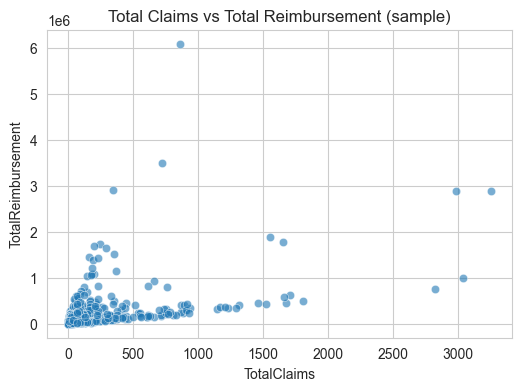

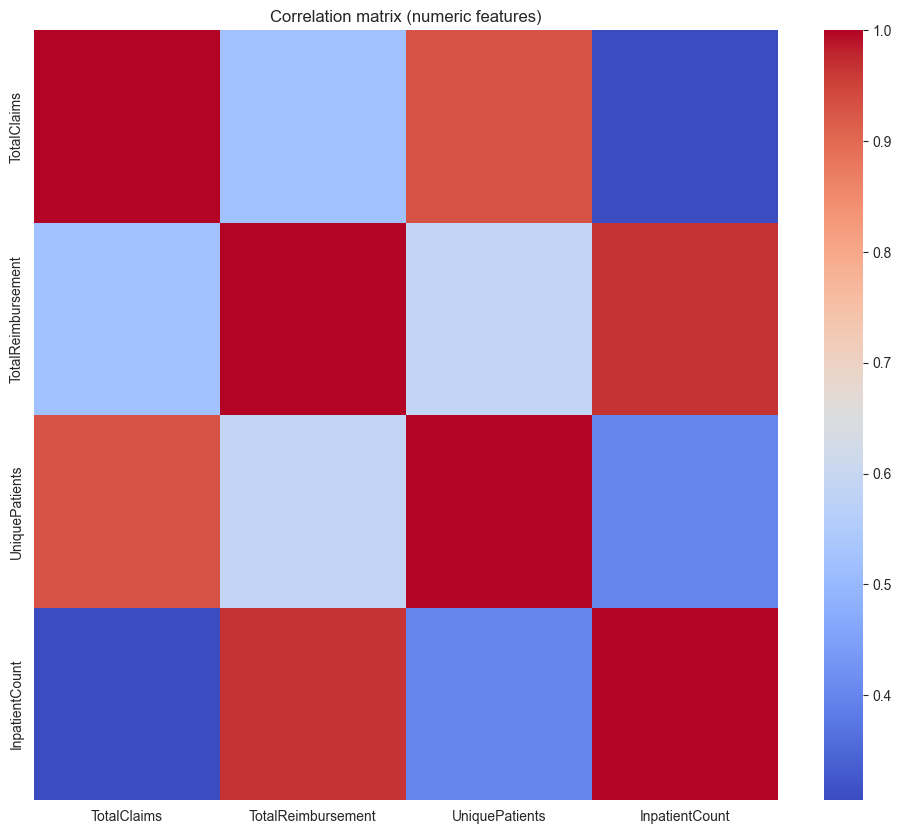


EDA complete. Next: Notebook 2 (modeling & evaluation) will read './data/processed_train_data.csv'


In [25]:
# ---------------------------
# 10. Exploratory Visualizations (core plots required by rubric)
# ---------------------------
print("\n--- Generating core EDA plots ---")
sns.set_style("whitegrid")

# A. Target class distribution
if 'Target' in final_dataset.columns:
    plt.figure(figsize=(5,4))
    ax = sns.countplot(x='Target', data=final_dataset)
    labels_map = {0:'Legit', 1:'Fraud'}
    ax.set_xticklabels([labels_map.get(x, str(x)) for x in ax.get_xticks()])
    plt.title('Provider Target Distribution')
    plt.xlabel('Provider Status')
    plt.ylabel('Count')
    plt.show()
else:
    print("Skipping target distribution plot (no Target column).")

# B. Distribution of AvgClaimCost (log-scale for heavy tails)
if 'AvgClaimCost' in final_dataset.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(final_dataset['AvgClaimCost'].replace([np.inf,-np.inf], np.nan).dropna(), bins=50, kde=True)
    plt.title('Distribution of Avg Claim Cost (provider-level)')
    plt.xlabel('Average claim reimbursement')
    plt.show()

# C. Claims vs Total Reimbursement colored by Target (sample if large)
if 'TotalClaims' in final_dataset.columns and 'TotalReimbursement' in final_dataset.columns:
    sample = final_dataset.sample(min(2000, len(final_dataset)), random_state=42)
    plt.figure(figsize=(6,4))
    if 'Target' in final_dataset.columns:
        sns.scatterplot(data=sample, x='TotalClaims', y='TotalReimbursement', hue='Target', alpha=0.6)
    else:
        sns.scatterplot(data=sample, x='TotalClaims', y='TotalReimbursement', alpha=0.6)
    plt.title('Total Claims vs Total Reimbursement (sample)')
    plt.show()

# D. Feature correlation heatmap (numeric only)
num = final_dataset.select_dtypes(include=[np.number]).drop(columns=['Target'], errors='ignore')
if num.shape[1] > 1:
    plt.figure(figsize=(12,10))
    corr = num.corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm')
    plt.title('Correlation matrix (numeric features)')
    plt.show()

# E. Boxplot comparisons for selected features (fraud vs legit)
if 'Target' in final_dataset.columns:
    feats = ['AvgClaimCost','ClaimsPerPatient','InpatientRatio','MeanChronicCount','MeanAge']
    available_feats = [f for f in feats if f in final_dataset.columns]
    for f in available_feats:
        plt.figure(figsize=(6,4))
        sns.boxplot(x='Target', y=f, data=final_dataset)
        plt.title(f'{f}: Fraud vs Legit')
        plt.xticks([0,1], ['Legit','Fraud'])
        plt.show()

print("\nEDA complete. Next: Notebook 2 (modeling & evaluation) will read './data/processed_train_data.csv'")


